# Implementation

In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

## Quantization

### Section A

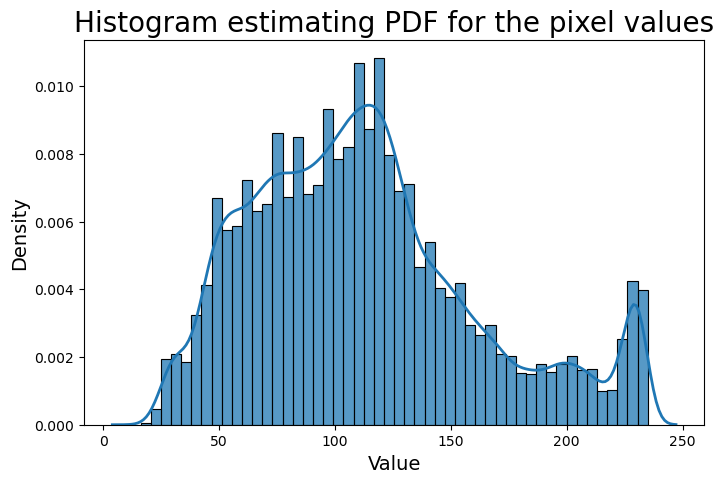

In [3]:
# path to the image file
img_path = 'houses.png'

# plot the pixel-value histogram
img = np.asarray(Image.open(img_path))
values = img.flatten()
fig, ax = plt.subplots(figsize=(8, 5))
sns.histplot(values, bins=50, stat="density", ax=ax, label='Empirical Density')
sns.kdeplot(values, ax=ax, linewidth=2, label='Estimated PDF')
plt.xlabel('Value', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Histogram estimating PDF for the pixel values', fontsize=20)
plt.show()

## Section B

We have $b$ bits, therefore, we have $k:=2^b$ representation levels $\{r_i\}_{i=1}^{2^b}$ and $k-1=2^b-1$ decision boundaries $\{d_i\}_{i=1}^{2^b-1}$.

We have seen in the tutorial that uniform quantization has the following form:

1. $\textbf{Uniform decision levels} \quad - \quad$
        $
           d_i = \varphi_L + i\,\Delta,
           \qquad 0 \le i \le k
        $

2. $\textbf{Uniform representation levels} \quad - \quad$
        $
           r_i = \varphi_L + \left(i - \tfrac{1}{2}\right)\Delta,
           \qquad 1 \le i \le k
        $

3. $\textbf{Uniform quantisation function} \quad - \quad$
        $
           Q(x) =
           \varphi_L + \Bigl( \Bigl\lfloor \tfrac{x - \varphi_L}{\Delta} \Bigr\rfloor + \tfrac{1}{2} \Bigr)\,\Delta
        $


where $\Delta = \frac{\phi_L - \phi_H}{k}$ - is the length of each interval

In [4]:
PHI_L = 0
PHI_H = 255

# decision levels
def uniformly_quantize(img: np.array, b: int) -> np.array:
    d = list()
    r = list()
    k = 2 ** b
    
    delta = (PHI_H - PHI_L) / k

    for i in range(k):
        d_i = PHI_L + (i * delta)
        r_i = PHI_L + (((i + 1) - 0.5) * delta)
        d.append(d_i)
        r.append(r_i)

    d.append(PHI_H)

    quantized_img = np.round(PHI_L + (((np.floor((img - PHI_L) / delta)) + 0.5) * delta))

    return r, d, quantized_img

def compute_mse(img: np.array, quantized_img: np.array) -> float:
    return ((values - quantized_img) ** 2).mean()

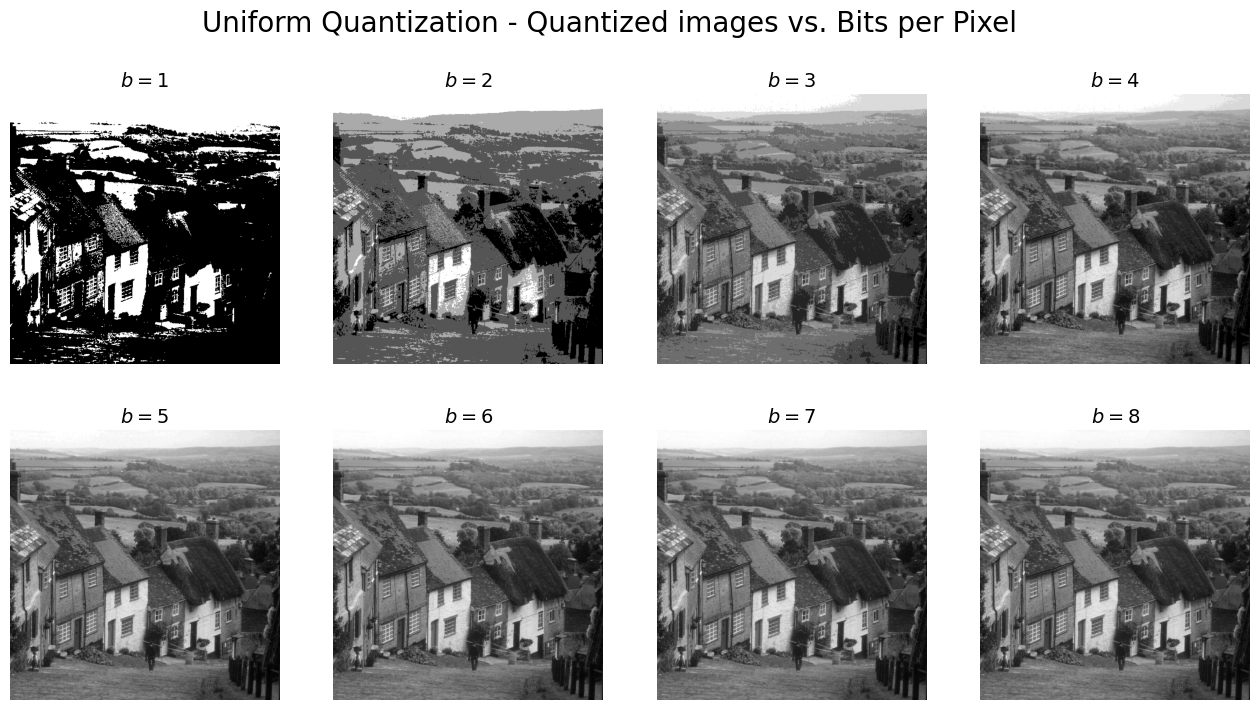

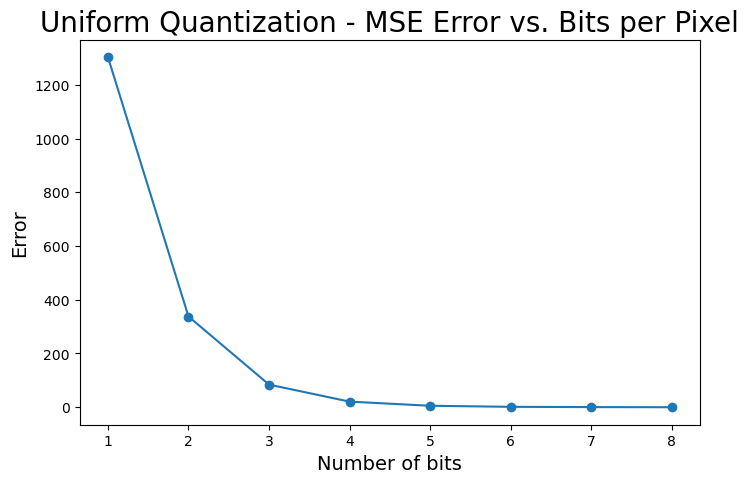

In [18]:
mse_errors = list()
fig, axes = plt.subplots(2, 4, figsize=(16,8))
fig.suptitle('Uniform Quantization - Quantized images vs. Bits per Pixel', fontsize=20)
for bits, ax in enumerate(axes.ravel()):
    representation, decision, quantized_img = uniformly_quantize(img=values, b=bits+1)
    ax.set_axis_off()
    ax.imshow(quantized_img.reshape(512, 512), cmap='gray')
    ax.set_title(f"$b={bits+1}$", fontsize=14)
    mse = compute_mse(values, quantized_img)
    mse_errors.append(mse)

plt.savefig('q_image.png')

plt.figure(figsize=(8,5))
plt.plot(np.arange(1, 9), mse_errors, marker='o')
plt.title('Uniform Quantization - MSE Error vs. Bits per Pixel', fontsize=20)
plt.xlabel('Number of bits', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.show()

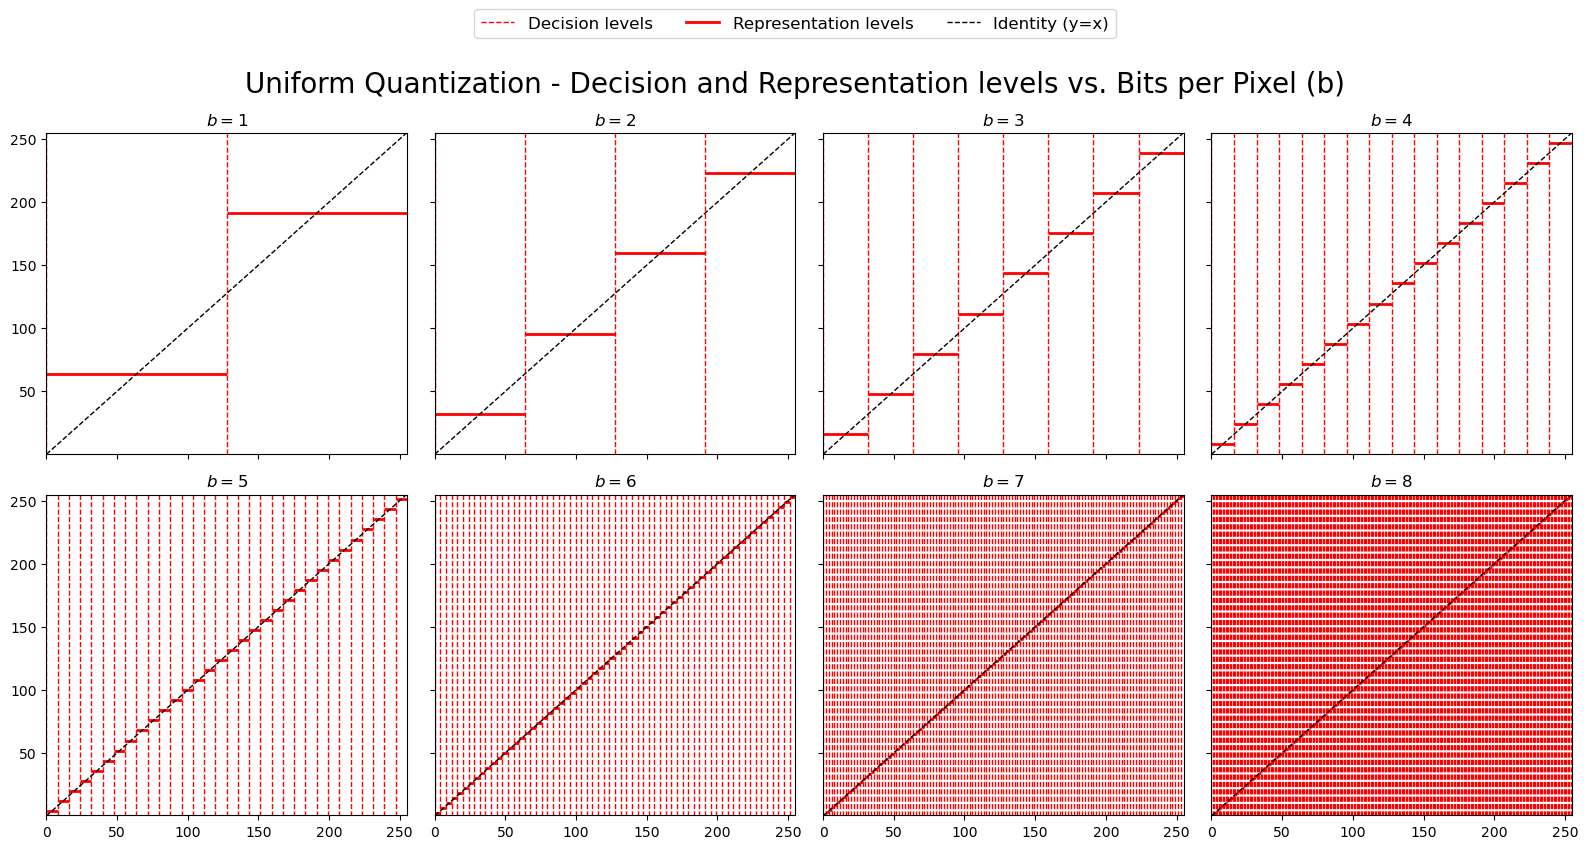

In [6]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharex=True, sharey=True)
fig.suptitle('Uniform Quantization - Decision and Representation levels vs. Bits per Pixel (b)', fontsize=20)

for b, ax in enumerate(axes.ravel()):
    representation, decision, quantized_img = uniformly_quantize(img=values, b=b+1)
    
    # vertical decision levels
    for i, d in enumerate(decision[:-1]):
        ax.vlines(x=d,
                  ymin=0,
                  ymax=256,
                  colors='red',
                  linestyles='--',
                  linewidth=1)

    # 2) horizontal representation levels
    for i in range(len(representation)):
        ax.hlines(y=representation[i],
                  xmin=decision[i],
                  xmax=decision[i+1],
                  colors='red',
                  linestyles='-',
                  linewidth=2)

    # identity line for reference
    ax.plot(decision, decision, 'k--', linewidth=1)

    ax.set_xticks(np.arange(0, 300, 50))  
    ax.set_yticks(np.arange(0, 300, 50))
    ax.set_title(f'$b={b+1}$')

    # set axis limits
    ax.set_xlim(decision[0], decision[-1])
    ax.set_ylim(representation[0], representation[-1])

# build our legend handles
legend_elements = [
    Line2D([0], [0], color='red',   linestyle='--', lw=1, label='Decision levels'),
    Line2D([0], [0], color='red',   linestyle='-',  lw=2, label='Representation levels'),
    Line2D([0], [0], color='k',     linestyle='--', lw=1, label='Identity (y=x)'),
]

# put legend 
fig.legend(handles=legend_elements,
           loc='lower center',
           ncol=3,
           bbox_to_anchor=(0.5, 1.01),
           fontsize=12)

plt.tight_layout()
plt.show()

### Section C

The Expected Squared Error (ESE), given the density of the pixel-values (continous) is:

$$
\sum_{i=1}^{k} \int_{d_{i-1}}^{d_i} (x - r_i)^2 p(x)\,dx
$$

This easily translates to the discrete approximation of the ESE, given a PDF histogram:

$$
\sum_{i=1}^{k} \sum_{x = d_{i-1}}^{d_i - 1} (x - r_i)^2 \cdot \hat{p}(x)
$$

where $\quad
\hat{p}(x) = \frac{h(x)}{\sum_{j} h(j)}$, and $h(x)$ is the count of how many times the intensity of a pixel $x$


In [31]:
def compute_ese(hist: np.array, representations: np.array, decisions: np.array) -> float:
    """Computes Approximated ESE (Expected Squared Error) between the quantization defined by the given representation and decision levels, and the image with this PDF"""
    n_pixels = hist.sum()
    pdf = hist / n_pixels
    
    curr_l, curr_h = decisions[0], decisions[1]
    counter = 0
    mse = 0
    
    # quantize the image according to the given levels
    for val, count in enumerate(hist):
        if not (curr_l <= val < curr_h):
            counter += 1
            curr_l, curr_h = decisions[counter], decisions[counter+1]
        Q = representations[counter]
        mse += (pdf[val] * ((Q - val) ** 2))
    return mse
                    

In [36]:
def lloyd_max(histogram: list, decisions: np.array, epsilon: float) -> (np.array, np.array):
    histogram = np.asarray(histogram, dtype=float)
    pdf = histogram / histogram.sum()
    
    # make a float‐copy of decisions
    decisions = decisions.astype(float).copy()
    N = len(decisions) - 1
    
    # storage for representation levels r_i
    representations = np.zeros(N, dtype=float)
    error_margin = np.inf
    old_error = np.inf

    n_iter = 0
    
    # intensities axis [0..L-1]
    x_axis = np.arange(len(pdf))

    print(f"Old Representations: {representations}")
    print(f"Old Decisions: {decisions}")
    
    while error_margin > epsilon:
        n_iter += 1
        
        # update r_i
        new_repr = np.zeros_like(representations)
        for i in range(N):
            di = int(np.round(decisions[i]))
            dip1 = int(np.round(decisions[i+1]))
            p  = pdf[di:dip1]  # probabilities in bin
            if p.sum() > 0:
                # weighted average of intensities
                new_repr[i] = np.dot(x_axis[di:dip1], p) / p.sum()
            else:
                # empty interval handling
                new_repr[i] = 0.5 * (d0 + d1)

        print(f"New Representations: {new_repr}")
        
        # update d_i
        new_dec = decisions.copy()
        for i in range(1, N):
            new_dec[i] = 0.5 * (new_repr[i-1] + new_repr[i])

        print(f"New Decisions: {new_dec}")
        
        # compute MSE
        new_error = compute_ese(histogram, new_repr, new_dec)
        print(f"Iteration: {n_iter}, Error: {new_error}")
        error_margin = old_error - new_error
        old_error = new_error
    
    return decisions, representations
            
                

### Section D

In [39]:
hist = Image.open(img_path).histogram()
uniform_dec = np.array([0, 32, 64, 96, 128, 160, 192, 224, 256])
d, r = lloyd_max(hist, uniform_dec, 0.005)

Old Representations: [0. 0. 0. 0. 0. 0. 0. 0.]
Old Decisions: [  0.  32.  64.  96. 128. 160. 192. 224. 256.]
New Representations: [ 27.58477509  50.74367772  79.83791733 111.61419539 141.40945455
 173.27975986 206.111      229.54654186]
New Decisions: [  0.          39.1642264   65.29079752  95.72605636 126.51182497
 157.3446072  189.69537993 217.82877093 256.        ]
Iteration: 1, Error: 71.03191812586867
New Representations: [ 27.58477509  50.74367772  79.83791733 111.61419539 141.40945455
 173.27975986 206.111      229.54654186]
New Decisions: [  0.          39.1642264   65.29079752  95.72605636 126.51182497
 157.3446072  189.69537993 217.82877093 256.        ]
Iteration: 2, Error: 71.03191812586867


## Subsampling and Reconstruction

## Hadamard, Hadamard-Walsh, and Haar matrices

### Section A

In [2]:
# recursive definition of the Hadamard matrix
def create_hadamard_matrix(n: int) -> np.array:

    # base case
    H2 = (1 / np.sqrt(2)) * np.array([
                    [1,  1],
                    [1, -1]
        ])
    if n == 1:
        return H2
    
    return np.kron(H2, create_hadamard_matrix(n-1))

[[ 0.5  0.5  0.5  0.5]
 [ 0.5 -0.5  0.5 -0.5]
 [ 0.5  0.5 -0.5 -0.5]
 [ 0.5 -0.5 -0.5  0.5]]


### Section B